In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer

from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
data_dir = '~/Projects/Datasets/public_news_set'
train_file = "multimodal_train_cleaned_sample.tsv"
test_file = "multimodal_test_cleaned_sample.tsv"
valid_flie = "multimodal_valid_cleaned_sample.tsv"

In [3]:
def same_seed(seed):
    '''
    Fixes random number generator seeds for reproducibility'''
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

same_seed(123)

In [4]:
# IDs to labels
label2id = {0: "True", 1: "Satire/Parody", 2: "Misleading Content", 3: "Imposter", 4: "False connection", 5: "Manipulated Content"}
labels = [label2id[i] for i in range(6)]
labels

['True',
 'Satire/Parody',
 'Misleading Content',
 'Imposter',
 'False connection',
 'Manipulated Content']

In [5]:
mid_train = pd.read_csv(os.path.join(data_dir, train_file), sep='\t')
mid_test = pd.read_csv(os.path.join(data_dir, test_file), sep='\t')
mid_val = pd.read_csv(os.path.join(data_dir, valid_flie), sep='\t')

In [6]:
import nltk
import re
nltk.download("stopwords")
from nltk.corpus import stopwords

def text_preprocessing(sent):
    """
    - Remove entity mentions (e.g. '@united')
    - Correct errors (e.g. '&amp;' to '&')
    @param  text (str): a string to be processed
    @return text (str): the processed string
    """
    sent = re.sub(r'(@.*?)[\s]', ' ', sent)
    sent = re.sub(r'&amp;', '&', sent)
    sent = re.sub(r'\s+', ' ', sent).strip()
    return sent


[nltk_data] Downloading package stopwords to /home/yangu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
def fillter_data(df):
    df = df.filter(['clean_title', '6_way_label']).rename(columns={"clean_title": "text", "6_way_label": "label"})
    df['label_text'] = df['label'].apply(lambda x:label2id[x])
    return df

In [8]:
mid_train = fillter_data(mid_train)
mid_test = fillter_data(mid_test)
mid_val = fillter_data(mid_val)

In [9]:
mid_train

,text,label,label_text
0,red skull,4,False connection
1,cafe in bangkok with the cutest employees ever...,0,True
2,he betrayed him,4,False connection
3,alderman wants to know exactly what bong shops...,0,True
4,man accused of stalking scots police officer s...,0,True
...,...,...,...
109144,oh my,4,False connection
109145,yo dawg,4,False connection
109146,cool guys dont look at explosions,4,False connection
109147,does this guy ever help out,4,False connection


In [10]:
mid_train.text = mid_train.text.apply(text_preprocessing)
mid_test.text = mid_test.text.apply(text_preprocessing)
mid_val.text = mid_val.text.apply(text_preprocessing)

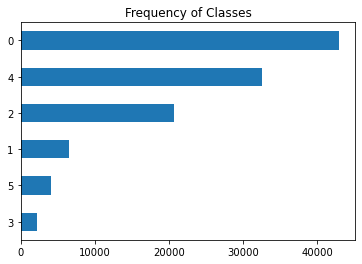

In [11]:
mid_train['label'].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

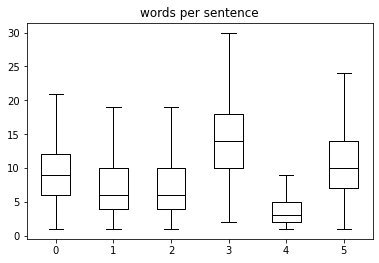

In [12]:
mid_train['words per sentence'] = mid_train['text'].str.split().apply(len)
mid_train.boxplot("words per sentence", by='label', grid=False, showfliers=False, color='black')
plt.suptitle("")
plt.xlabel("")
plt.show()

In [13]:
from transformers import AutoTokenizer, AutoModel

model_ckpt = "distilbert-base-uncased"
# model_ckpt = "bert-base-uncased"
# model_ckpt = "roberta-base"
# model_ckpt = "xlnet-base-cased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [14]:
def tokenize(text):
    return tokenizer(text, truncation=True, padding="max_length", max_length=20)

In [15]:
mid_train['text'] = mid_train['text'].apply(tokenize)
mid_val['text'] = mid_val['text'].apply(tokenize)
mid_test['text'] = mid_test['text'].apply(tokenize)

In [16]:
mid_train['input_ids'], mid_train['attention_mask'] = mid_train['text'].apply(lambda x: x['input_ids']), mid_train['text'].apply(lambda x: x['attention_mask'])
mid_val['input_ids'], mid_val['attention_mask'] = mid_val['text'].apply(lambda x: x['input_ids']), mid_val['text'].apply(lambda x: x['attention_mask'])
mid_test['input_ids'], mid_test['attention_mask'] = mid_test['text'].apply(lambda x: x['input_ids']), mid_test['text'].apply(lambda x: x['attention_mask'])

In [17]:
# mid_train = mid_train.filter(['input_ids', 'attention_mask', 'label'])
# mid_val = mid_val.filter(['input_ids', 'attention_mask', 'label'])
# mid_test = mid_test.filter(['input_ids', 'attention_mask', 'label'])

In [18]:
class Mid_dataset(Dataset):
    def __init__(self, df):
        df.dtype = np.float64
        self.input_ids = df['input_ids'].values
        self.attention_mask = df['attention_mask'].values
        self.label = df['label'].values

    def __getitem__(self, idx):
        input_ids = torch.Tensor(self.input_ids[idx]).int()
        attention_mask = torch.Tensor(self.attention_mask[idx]).int()
        label = self.label[idx]
        return {"input_ids": input_ids, "attention_mask": attention_mask, "label": label}

    def __len__(self):
        return len(self.label)

In [19]:
def extract_hidden_states(batch):
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state

    return {'hidden_state': last_hidden_state[:, 0].cpu().numpy()}

In [20]:
batch_size = 64
trainset = Mid_dataset(mid_train)
train_loader = DataLoader(trainset, batch_size=batch_size)
valset = Mid_dataset(mid_val)
valid_loader = DataLoader(valset, batch_size=batch_size)
testset = Mid_dataset(mid_test)
test_loader = DataLoader(testset, batch_size=batch_size)

In [21]:
# Extract hidden states using pre_trained model
# for item in tqdm(train_loader, total=len(train_loader)):
#     extract_hidden_states(item)

In [22]:
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay, confusion_matrix

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}


def plot_confusion_matrix(y_preds, y_true):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

In [25]:
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

from transformers import Trainer, TrainingArguments

logging_steps = len(trainset) // batch_size
model_name = "text-distilbert-finetuned-emotion"
training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=10,
    learning_rate=2e-5,
    per_gpu_train_batch_size=batch_size,
    per_gpu_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    log_level='error'
)

In [26]:
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=trainset,
    eval_dataset=valset,
    tokenizer=tokenizer
)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.780100,0.644456,0.766051,0.755574
2,0.571000,0.620540,0.783495,0.775530
3,0.447400,0.643266,0.781589,0.777746
4,0.346500,0.706576,0.776092,0.772081
5,0.269400,0.764360,0.774333,0.772900
6,0.208800,0.838902,0.770595,0.768305
7,0.167200,0.942021,0.770302,0.768084
8,0.137100,0.989129,0.765098,0.764800
9,0.115600,1.036726,0.769129,0.766404
10,0.100200,1.069714,0.768836,0.766849


TrainOutput(global_step=17060, training_loss=0.3141961215179663, metrics={'train_runtime': 1222.3656, 'train_samples_per_second': 892.933, 'train_steps_per_second': 13.957, 'total_flos': 5648326365751200.0, 'train_loss': 0.3141961215179663, 'epoch': 10.0})

In [30]:
preds_output = trainer.predict(testset)

In [31]:
preds_output.metrics

{'test_loss': 1.0601067543029785,
 'test_accuracy': 0.7703019642333626,
 'test_f1': 0.7684143679054639,
 'test_runtime': 3.6389,
 'test_samples_per_second': 3749.466,
 'test_steps_per_second': 58.809}

In [32]:
y_preds = np.argmax(preds_output.predictions, axis=1)
y_valid = np.array(mid_test['label'])

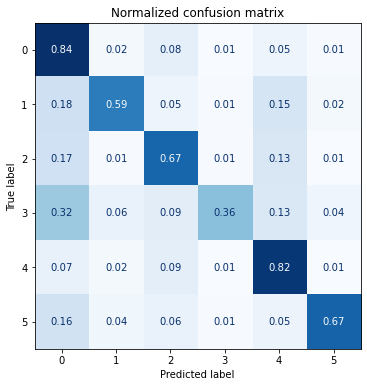

In [33]:
plot_confusion_matrix(y_preds, y_valid)

In [ ]:
# Model 2
class MidClassifier(nn.Module):
    def __init__(self, finetune=True):
        super().__init__()
        self.input_dim, self.hidden, self.output_dim = 768, 50, 6
        self.pretrained = AutoModel.from_pretrained(model_ckpt)

        self.classifier = nn.Sequential(
            nn.Linear(self.input_dim, self.hidden),
            nn.ReLU(),
            nn.Linear(self.hidden, self.output_dim)
        )

        if not finetune:
            for param in self.pretrained.parameters():
                param.requires_grad = False

    def forward(self, x):
        output = self.pretrained(x)
        # return the last hidden state of pretrained model
        last_hidden_state = output.last_hiddent_state[:, 0]
        logits = self.classifier(last_hidden_state)
        return logits


In [ ]:
def train(model, train_loader, val_loader, epochs=4, evaluation=True):
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-5, eps=1e-8)
    loss_fn = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        model.train()
        loss_total = 0
        for step, batch in enumerate(train_loader):
            i_input_ids, i_attention_masks, i_labels = tuple(t.to(device) for t in batch)
            model.zero_grad()
            logits = model(i_input_ids, i_attention_masks)

            loss = loss_fn(logits, i_labels)

            loss.backward()
            optimizer.step()

            # evaluation for each batch
            ...


In [ ]:
def evaluation():
    ...

In [33]:
torch.cuda.empty_cache()
del Mid_dataset